# Anaylsis Bike Sharing Data

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib as plt
%matplotlib inline
from sqlalchemy import create_engine
import requests
import time

import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin
import geoplot

### Datasets

- Raw data: raw.csv

- Categorized in Trip and accessible: preprocessed.csv

- Cleaned according to plausability: cleaned.csv

- routed routed.csv

- Trip Dataset: pseudonomysed.csv
    - pseudonomysed
    - trip ID, start time, end time, start location, stop location, duration, estimated distance<

# Preprocessing

## get data from database

In [108]:
dbhost = ''
dbname = ''
dbuser = ''
dbpassword = ''

In [166]:
sql = """
select *
from (
    select  "bikeId", "providerId", "timestamp", latitude, longitude,
			lag("bikeId") over (order by "bikeId" ASC, "timestamp" ASC) as prev_id,
            lead("bikeId") over (order by "bikeId" ASC, "timestamp" ASC) as next_id,
            lag("latitude") over (order by "bikeId" ASC, "timestamp" ASC) as prev_lat,
			lag("longitude") over (order by "bikeId" ASC, "timestamp" ASC) as prev_lon,
            lead("latitude") over (order by "bikeId" ASC, "timestamp" ASC) as next_lat,
            lead("longitude") over (order by "bikeId" ASC, "timestamp" ASC) as next_lon
    from public."bikeLocations"
    )x
	where ("bikeId" <> next_id) or
		   ("bikeId" <> prev_id) or
		   (latitude <> next_lat or longitude <> next_lon or latitude <> prev_lat or longitude <> prev_lon)
	
	--keep first and last instance of bike (bikeId <> prev_id or bikeId <> next_id)
	--keep all changes inbetween, where bike_Id is equal to next_id but lat or lon changed to prev or next
"""

engine = create_engine('postgresql://' + dbuser + ':' + dbpassword + '@' + dbhost + ':5432/' + dbname)
df = pd.read_sql_query(sql,con=engine)

In [167]:
df.to_csv('../../data/raw.csv', index_label= 'id')

## preprocess

In [151]:
# df = pd.read_csv('../../data/raw.csv', parse_dates=['timestamp'])

In [168]:
# if data is cleaned (in sql) then create data set for trips and accessible periods

def preprocess(df):
    
    MODE_TRIP = 'trip'
    MODE_ACCESS = 'accessible'

    df['end_timestamp'] = None
    df['next_lat'] = None
    df['next_lon'] = None
    df['mode'] = None

    df.sort_values(by=['bikeId', 'timestamp'], inplace = True)
    df['end_timestamp'] = df.timestamp.shift(-1)

    # set location of next occurence (use -1 so the round doesnt crash for getting mode)
    df['next_lat'] = np.where(df.bikeId == df.bikeId.shift(-1), df.latitude.shift(-1), -1)
    df['next_lon'] = np.where(df.bikeId == df.bikeId.shift(-1), df.longitude.shift(-1), -1)
    
    # if the bike has moved its a trip, otherwise the bike was accessible at its location
    # round to 4 digits for lat lon
    df['mode'] = np.where((df.latitude.round(4) != df.next_lat.round(4)) | (df.longitude.round(4) != df.next_lon.round(4)), MODE_TRIP, MODE_ACCESS)
    
    # if bike Id is not the same as next, then this is the final time stamp and the next_timestamp is set to None
    df['end_timestamp'] = df.end_timestamp.where(df.bikeId == df.bikeId.shift(-1),None, axis=0)
    df['duration'] = df.end_timestamp - df.timestamp
    
    # delete last instances of all bikes
    df = df[df.next_lat.notnull()]
    
    return df

In [169]:
df = preprocess(df)

In [170]:
df.to_csv('../../data/preprocessed.csv', index_label= 'id')

## Data Cleaning

In [155]:
# df = pd.read_csv('../../data/preprocessed.csv', parse_dates=['timestamp','end_timestamp'])

In [171]:
def cleaning(df):
    # switch lat lon where it's wrong (for Berlin)
    temp = df.loc[(df.longitude > 40),'latitude'].copy(deep=True)

    df.loc[(df.longitude > 40),'latitude'] = df.loc[(df.longitude > 40),'longitude']
    df.loc[(df.longitude > 40),'longitude'] = temp
    
    temp0 = df.loc[(df.longitude > 40),'next_lat'].copy(deep=True)

    df.loc[(df.next_lon > 40),'next_lat'] = df.loc[(df.longitude > 40),'next_lon']
    df.loc[(df.next_lon > 40),'next_lon'] = temp0
    
    temp1 = df.loc[(df.prev_lon > 40),'prev_lat'].copy(deep=True)
    
    df.loc[(df.prev_lon > 40),'prev_lat'] = df.loc[(df.longitude > 40),'prev_lon']
    df.loc[(df.prev_lon > 40),'prev_lon'] = temp1
    
    # delete instances with unplausible locations (outside of Berlin)
    df.drop(df[df.longitude > 13.8].index, inplace=True)
    df.drop(df[df.next_lon > 13.8].index, inplace=True)

    df.drop(df[df.longitude < 13.0].index, inplace=True)
    df.drop(df[df.next_lon < 13.0].index, inplace=True)

    df.drop(df[df.latitude > 52.7].index, inplace=True)
    df.drop(df[df.next_lat > 52.7].index, inplace=True)

    df.drop(df[df.latitude < 52.3].index, inplace=True)
    df.drop(df[df.next_lat < 52.3].index, inplace=True)

    df['duration'] = df.end_timestamp - df.timestamp
    
    # drop trips that are longer than 24 hours
    df = df.drop(df[(df['mode'] == 'trip') & (df.duration > datetime.timedelta(hours=24))].index)

    # drop trips before 1.4.2019 
    df = df.drop(df[df['timestamp'] <  pd.Timestamp(2019,4,1)].index)
    return df

    # TODO: drop trips that are shorter than 100 m
    # TODO: drop bikes that are faster than x km/h

In [172]:
df = cleaning(df)

In [173]:
df.to_csv('../../data/cleaned.csv', index_label = 'id')

## Routing

In [160]:
# delete trips with smaller than x distance
# routing only for trips (not accessible)

In [174]:
df['response'] = None
df['geometry'] = None
df['distance'] = None
df['calc_time'] = None
df['waypoints'] = None

In [4]:
def routing(start_lon, start_lat, end_lon, end_lat):
    start = str(start_lon) + ',' + str(start_lat)
    end = str(end_lon) + ',' + str(end_lat)
    params = {'start':start,
              'end':end,
              'modal':'bicycle'
             }
    r = requests.get('http://localhost:1717/route', params = params)
    response = r.json()
    return response

In [5]:
df = pd.DataFrame()
for chunk in pd.read_csv('../../data/cleaned.csv', index_col='id', parse_dates=['timestamp', 'end_timestamp'],chunksize=10000):
    start = time.time()
    chunk['response'] = None
    chunk['geometry'] = None
    chunk['distance'] = None
    chunk['calc_time'] = None
    chunk['waypoints'] = None
    chunk.loc[chunk['mode']=='trip', 'response'] = chunk.loc[chunk['mode']=='trip'].apply(lambda row: routing(row.longitude, row.latitude, row.next_lon, row.next_lat), axis=1)
    chunk.loc[chunk['mode']=='trip', 'geometry'] = chunk.loc[chunk['mode']=='trip']['response'].apply(lambda row: row['routes'][0]['geometry'])
    chunk.loc[chunk['mode']=='trip', 'distance'] = chunk.loc[chunk['mode']=='trip']['response'].apply(lambda row: row['routes'][0]['distance'])
    chunk.loc[chunk['mode']=='trip', 'calc_time'] = chunk.loc[chunk['mode']=='trip']['response'].apply(lambda row: row['routes'][0]['duration'])
    chunk.loc[chunk['mode']=='trip', 'waypoints'] = chunk.loc[chunk['mode']=='trip']['response'].apply(lambda row: row['waypoints'])
    end = time.time()
    print(end - start)
    df = df.append(chunk)
    break

19.178982257843018


In [661]:
df.to_csv('../../data/routed.csv')

In [ ]:
df.to_json('../../data/routed.json', orient='records')

#### Check for unplausible data (e.g. super fast rides --> Car)

## Pseudonymisation 

https://datasmart.ash.harvard.edu/news/article/civic-analytics-network-dockless-mobility-open-letter
https://data.louisvilleky.gov/dataset/dockless-vehicles

In [16]:
# pseudonomoysed
pseudon = df.copy(deep=True)
pseudon['starttime'] = pseudon.timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))
pseudon['endtime'] = pseudon.end_timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))
pseudon.reset_index()
pseudon.latitude = pseudon.latitude.round(3)
pseudon.longitude = pseudon.longitude.round(3)
pseudon.next_lat = pseudon.next_lat.round(3)
pseudon.next_lon = pseudon.next_lon.round(3)
pseudon = pseudon[pseudon['mode'] == 'trip'].drop(['providerId', 'bikeId', 'timestamp', 'end_timestamp', 'next_id','prev_id', 'mode', 'prev_lat', 'prev_lon', 'response', 'calc_time','geometry', 'waypoints'], axis=1).copy(deep=True)

In [17]:
pseudon.head()

,latitude,longitude,next_lat,next_lon,duration,distance,starttime,endtime
id,,,,,,,,
2,52.510,13.406,52.532,13.421,0 days 04:31:59.428520000,3238.3,2019-04-05 13:30:00,2019-04-05 18:15:00
6,52.532,13.421,52.530,13.418,0 days 01:03:59.502937000,516.4,2019-04-06 12:45:00,2019-04-06 13:45:00
8,52.530,13.418,52.516,13.398,0 days 00:24:00.581760000,2388.2,2019-04-07 11:15:00,2019-04-07 11:30:00
10,52.516,13.398,52.516,13.376,0 days 00:16:00.452547000,1783.2,2019-04-07 12:00:00,2019-04-07 12:15:00
18,52.476,13.447,52.504,13.443,0 days 15:08:00.178330000,4218.1,2019-04-11 18:45:00,2019-04-12 10:00:00


In [ ]:
# pseudon.to_csv('../../data/pseudonomysed.csv', index_label='id')

# Analysis

In [62]:
df['mode'].value_counts()

accessible    2617149
trip          2179357
Name: mode, dtype: int64

In [3]:
df['mode'].value_counts()

accessible    2743299
trip          2064721
Name: mode, dtype: int64

In [2]:
df = pd.read_csv('../../data/cleaned.csv', parse_dates=['timestamp','end_timestamp', 'duration'])

In [6]:
df.duration = df.end_timestamp - df.timestamp

In [7]:
dist = df[df.distance.notnull()]

In [21]:
dist.groupby('providerId').distance.describe()

,count,unique,top,freq
providerId,,,,
0,4449.0,3840.0,0.0,23.0


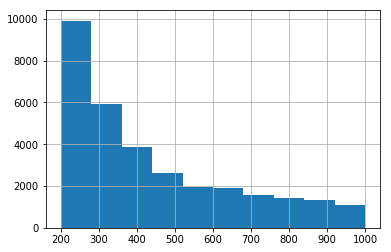

In [71]:
dist[dist.distance > 100].distance.hist(range=(200, 2000))

In [1]:
#dist[dist.distance > 200].distance.value_counts()

In [69]:
dist[dist.distance > 100].describe()

,bikeId,providerId,latitude,longitude,prev_id,next_id,prev_lat,prev_lon,next_lat,next_lon,duration,distance,calc_time
count,1.343250e+05,134325.000000,134325.000000,134325.000000,1.343250e+05,1.343250e+05,127708.000000,134325.000000,134325.000000,134325.000000,134126,134325.000000,134325.000000
mean,7.676697e+08,1.947746,52.512241,13.370533,7.676697e+08,7.676697e+08,52.511903,13.367610,52.432910,13.349247,0 days 02:20:05.418219,2884.246564,830.073481
std,1.802506e+08,0.222539,0.019494,0.048505,1.802506e+08,1.802506e+08,0.019404,0.048659,2.058258,0.554839,0 days 15:44:35.263895,3299.207159,892.717062
min,1.841760e+05,1.000000,52.434452,13.263792,1.841760e+05,1.841760e+05,52.459920,13.263792,-1.000000,-1.000000,0 days 00:00:06.225870,100.100000,15.300000
25%,8.100022e+08,2.000000,52.498712,13.330286,8.100022e+08,8.100022e+08,52.497873,13.325248,52.498575,13.329838,0 days 00:04:06.451638,228.400000,116.000000
50%,8.100034e+08,2.000000,52.511993,13.369098,8.100034e+08,8.100034e+08,52.511959,13.363803,52.511993,13.369010,0 days 00:15:59.639255,1382.600000,435.400000
75%,8.100045e+08,2.000000,52.524930,13.410304,8.100045e+08,8.100045e+08,52.523488,13.407374,52.524785,13.410007,0 days 00:47:53.849552,5009.100000,1380.900000
max,8.100063e+08,2.000000,52.574486,13.523591,8.100063e+08,8.100063e+08,52.560593,13.523591,52.574486,13.523556,53 days 14:52:05.278680,14252.200000,3818.600000


In [18]:
dist[dist.distance < 100].shape

(432298, 20)

In [66]:
dist[dist.duration > datetime.timedelta(minutes=5)].describe()

,bikeId,providerId,latitude,longitude,prev_id,next_id,prev_lat,prev_lon,next_lat,next_lon,duration,distance,calc_time
count,4.881670e+05,488167.000000,488167.000000,488167.000000,4.881670e+05,4.881670e+05,481600.000000,488167.000000,488167.000000,488167.000000,488167,488167.000000,488167.000000
mean,7.984664e+08,1.985784,52.511164,13.382816,7.984664e+08,7.984664e+08,52.511127,13.382462,52.511143,13.382826,0 days 02:18:24.114559,437.159092,133.668287
std,9.596500e+07,0.118382,0.021648,0.046398,9.596500e+07,9.596500e+07,0.021673,0.046523,0.021642,0.046412,0 days 16:43:32.634078,1504.701687,418.142826
min,1.841760e+05,1.000000,52.434452,13.263792,1.841760e+05,1.841760e+05,52.459920,13.263792,52.434452,13.263777,0 days 00:05:00.444690,0.000000,0.000000
25%,8.100024e+08,2.000000,52.493993,13.346835,8.100024e+08,8.100024e+08,52.493992,13.346141,52.493982,13.346876,0 days 00:15:46.007794,2.600000,0.900000
50%,8.100035e+08,2.000000,52.510766,13.384343,8.100035e+08,8.100035e+08,52.510746,13.384050,52.510742,13.384335,0 days 00:27:57.847473,12.700000,5.700000
75%,8.100046e+08,2.000000,52.528024,13.420752,8.100046e+08,8.100046e+08,52.528011,13.420492,52.527964,13.420839,0 days 00:59:59.835491,64.800000,42.600000
max,8.100063e+08,2.000000,52.574486,13.523591,8.100063e+08,8.100063e+08,52.560593,13.523591,52.574486,13.523556,63 days 16:39:59.796462,14252.200000,3818.600000


In [8]:
dist[dist.distance > 100].groupby('providerId').duration.describe()

,count,unique,top,freq
providerId,,,,
1.0,7019,6643,0 days 09:07:59.956992000,27
2.0,127306,100958,0 days 00:04:00.973432000,11


In [ ]:
df[df['mode'] == 'trip'].duration.describe()

In [ ]:
# histogram of minutes spent on trip
df.duration.apply(lambda x: x.seconds / 60).hist(range=(0,250))

In [ ]:
# average duration of trips and accesible quases

In [ ]:
df[df['mode'] == 'trip'].duration.describe()

In [ ]:
df[df['mode'] == 'accessible'].duration.describe()

In [75]:
dist.loc[:,'hourly_starttime'] = dist.timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 60)))

/Users/akapp/Documents/Allgemein/Packages/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/akapp/Documents/Allgemein/Packages/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
dist

In [90]:
counts = dist[dist.distance > 100][['bikeId', 'hourly_starttime']].groupby(['hourly_starttime']).count()

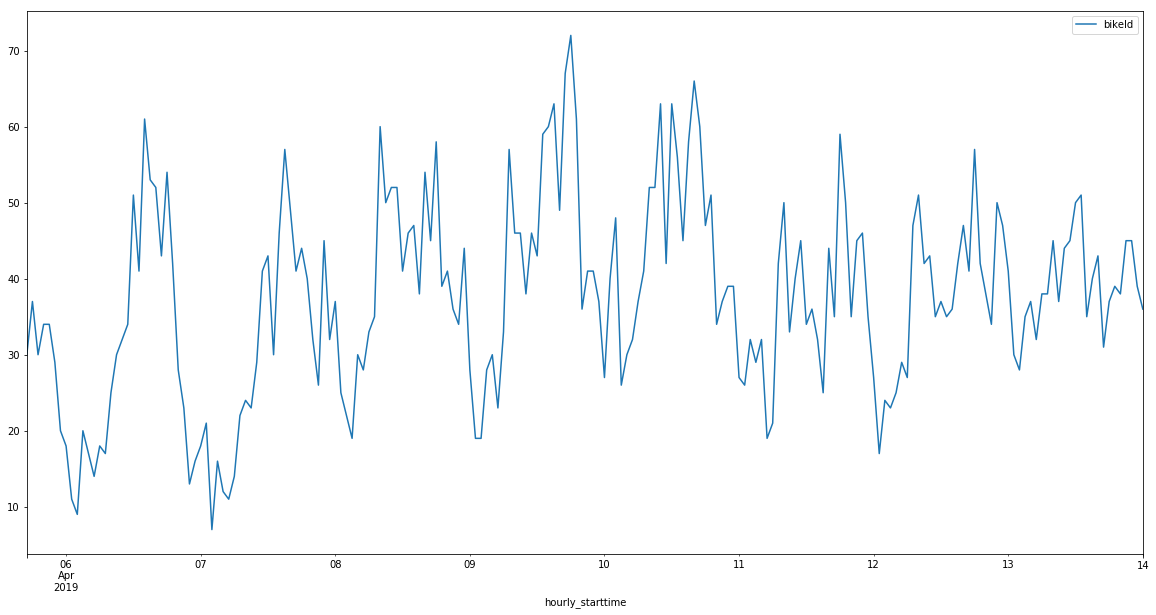

In [99]:
counts[100:300].plot(figsize=(20,10))

### original data

#### How many unique bike IDs are there (per provider)?

In [ ]:
# how many bikes are available / on a trip for each hour?
def get_unique_ids_per_day(df):
    daily_unique = pd.DataFrame()

    start_time = df.sort_values('timestamp').reset_index().loc[0,'timestamp']
    end_time = df.sort_values('timestamp').reset_index().loc[df.shape[0]-2, 'timestamp']
    times= []
    
    # get all desired times
    while start_time < end_time:
        times.append(start_time)
        start_time += datetime.timedelta(hours=24)
    
    daily_unique['time'] = times
    daily_unique['total'] = daily_unique.time.apply(lambda x: df[
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    daily_unique['nextbike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 0)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    daily_unique['lidlbike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 1)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    daily_unique['mobike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 2)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    
    return daily_unique
    

In [385]:
def get_unique_ids(df):
    unique_bikes = pd.DataFrame()
    unique_bikes = unique_bikes.append([([df.bikeId.unique().shape[0], df[(df.providerId == 0)].bikeId.unique().shape[0], 
             df[(df.providerId == 1)].bikeId.unique().shape[0],
             df[(df.providerId == 2)].bikeId.unique().shape[0]])])
    unique_bikes.columns = [['total', 'nextbike', 'lidlbike', 'mobike']]
    return unique_bikes

In [170]:
daily_uniques = get_unique_ids_per_day(df)

In [171]:
daily_uniques.describe()

,total,nextbike,lidlbike,mobike
count,105.000000,105.000000,105.000000,105.000000
mean,7202.828571,1026.580952,2168.895238,4007.352381
std,1740.188730,316.039517,836.469790,1288.964477
min,0.000000,0.000000,0.000000,0.000000
25%,7056.000000,962.000000,2241.000000,4172.000000
50%,7914.000000,1091.000000,2422.000000,4425.000000
75%,8245.000000,1206.000000,2544.000000,4635.000000
max,8788.000000,1598.000000,3125.000000,4962.000000


In [386]:
uniques = get_unique_ids(df)
uniques

,total,nextbike,lidlbike,mobike
0,14546,2390,2816,9340


In [184]:
# average trips per bike
df_trips = df[df['mode']=='trip']
df_trips.groupby(['bikeId', 'providerId']).count().groupby('providerId').describe()

level_0                                                            \
             count        mean         std  min    25%    50%    75%     max   
providerId                                                                     
0           2382.0   73.283795   34.313157  1.0   57.0   72.0   87.0   465.0   
1           3592.0  106.138363   41.804395  1.0   83.0  115.0  134.0   655.0   
2           9316.0  219.991305  223.889874  1.0  135.0  203.0  268.0  4445.0   

             index              ... waypoints      response                 \
             count        mean  ...       75%  max    count mean  std  min   
providerId                      ...                                          
0           2382.0   73.283795  ...       0.0  0.0   2382.0  0.0  0.0  0.0   
1           3592.0  106.138363  ...       0.0  0.0   3592.0  0.0  0.0  0.0   
2           9316.0  219.991305  ...       0.0  0.0   9316.0  0.0  0.0  0.0   

                                
            25%  50%  75%  max  
providerId                      
0           0.0  0.0  0.0  0.0  
1           0.0  0.0  0.0  0.0  
2           0.0  0.0  0.0  0.0  

[3 rows x 152 columns]

#### How much time is a bike used? 

#### how high is the utilization rate? (available bikes / all bikes)

In [611]:
# how many bikes are available / on a trip for each hour?
def count_bikes_in_mode(df, mode):
    bikes_accessible = pd.DataFrame()

    start_time = df.sort_values('timestamp').reset_index().loc[0,'timestamp']
    end_time = df.sort_values('timestamp').reset_index().loc[df.shape[0]-2, 'timestamp']
    times= []
    while start_time < end_time:
        times.append(start_time)
        start_time += datetime.timedelta(hours=36)
    
    bikes_accessible['time'] = times
    bikes_accessible['total'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    bikes_accessible['nextbike'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.providerId == 0)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    bikes_accessible['lidlbike'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.providerId == 1)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    bikes_accessible['mobike'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.providerId == 2)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    return bikes_accessible
    

In [612]:
accessible = count_bikes_in_mode(df.sort_values('timestamp'), 'accessible')

In [615]:
in_use = count_bikes_in_mode(df.sort_values('timestamp'), 'trip')

In [616]:
in_use.median()

total       1301.0
nextbike     141.0
lidlbike      78.0
mobike      1081.0
dtype: float64

In [613]:
accessible.median()

total       6065.0
nextbike     965.0
lidlbike    2647.0
mobike      2452.0
dtype: float64

In [ ]:
# still that high when cleaned??

In [618]:
in_use.median() / accessible.median()

total       0.214509
nextbike    0.146114
lidlbike    0.029467
mobike      0.440865
dtype: float64

#### Bike Availability: 
- Where are bikes available (per Planungsraum)? On average? On average weekdays / times?
- Distance between available bikes

#### how long is the life span of a bike? (first appearence and last appearence)
- is there periodical appearences?

In [195]:
# get data for lifespan

def lifespan (df):
    # each line one trip with start-loc and end-loc
    # for each bike ID
    start_timestamp = df.sort_values(by=['bikeId', 'timestamp']).drop_duplicates('bikeId', keep='first')
    last_timestamp = df.sort_values(by=['bikeId', 'timestamp'], ascending = False).drop_duplicates('bikeId', keep='first')
    start_timestamp.set_index('bikeId', inplace=True)
    last_timestamp.set_index('bikeId', inplace=True)
    return start_timestamp.join(last_timestamp[['timestamp']], rsuffix='_last')

#df_lifespan = pd.DataFrame()
#chunksize = 10 ** 8
#for chunk in pd.read_csv('raw_small.csv', chunksize=chunksize):
    #df_lifespan = df_lifespan.append(lifespan(chunk))
    
df_lifespan = lifespan(df)

#df_lifespan.to_csv('lifespan.csv')

In [2]:
df[['bikeId', 'providerId']].drop_duplicates().groupby('providerId').count()

NameError: name 'df' is not defined

#### where are bikes "moved"? (e.g. very fast rides by car)

In [8]:
dist['speed'] = (dist.distance/1000) / (dist.duration.apply(lambda x: x.total_seconds()/3600))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


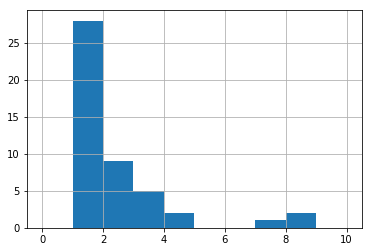

In [34]:
dist['speed'].apply(lambda x: round(x, 0)).value_counts().hist(range=(0,10))

In [35]:
#dist[dist.speed > 20]

In [9]:
dist['speed'].describe()

count     4449.0
unique    4427.0
top          0.0
freq        23.0
Name: speed, dtype: float64

## pseudonomysed trip data

In [ ]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf = gdf.to_crs(epsg=25833)

In [ ]:
geometry = [Point(xy) for xy in zip(df.next_lon, df.next_lat)]
gdf_end = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf_end = gdf_end.to_crs(epsg=25833)

In [ ]:
berlin = geopandas.read_file('lor_planungsraeume.geojson')
berlin = berlin.to_crs(epsg=25833)

In [ ]:
# map of accessible bikes
base = berlin.plot(color='white', edgecolor='black', figsize=(20,20))
gdf[(gdf['mode']=='accessible') & (gdf.latitude > 52.3) & (gdf.longitude > 13.0)& (gdf.latitude < 53.7) & (gdf.longitude < 13.7)].plot(ax=base, markersize=0.01, figsize=(20,20))

In [ ]:
# map of startpoints
gdf[(gdf['mode']=='trip')].plot(ax=base, markersize=0.01, figsize=(20,20))

In [ ]:
# map of endpoints
gdf_end[(gdf_end['mode']=='trip')].plot(ax=base, markersize=0.01, figsize=(20,20))

In [ ]:
# map both
start = gdf[(gdf['mode']=='trip')].plot(ax=base, markersize=0.01, figsize=(20,20), color='red')
gdf_end[(gdf_end['mode']=='trip')].plot(ax=start, markersize=0.01, figsize=(20,20))

In [ ]:
# heatmap (?)
import geoplot
ax = geoplot.kdeplot(gdf.head(100),
                     shade=True, shade_lowest=False,
                     clip=boroughs.geometry)
geoplot.polyplot(boroughs, ax=base)

#### How many bikes are in use at what point in time (weekday)?

In [4]:
# hour of day
df['hour_of_day'] = df.timestamp.apply(lambda x: x.time().hour)

In [5]:
# day of week
df['day_of_week'] = df.timestamp.apply(lambda x: x.weekday())

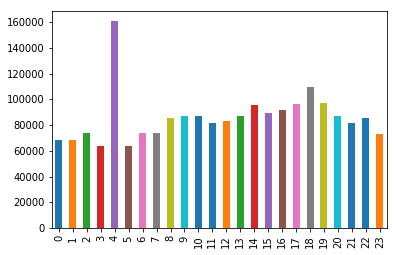

In [12]:
df[df['mode'] == 'trip'].hour_of_day.value_counts().sort_index().plot(kind='bar')

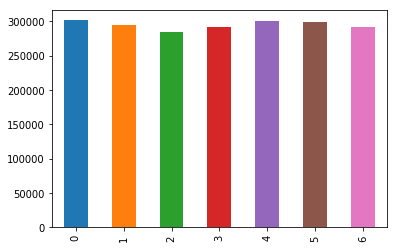

In [13]:
df[df['mode'] == 'trip'].day_of_week.value_counts().sort_index().plot(kind='bar')

In [ ]:
# see whole time on hourly / daily basis

In [298]:
df.loc[:,'hourly_starttime'] = df.timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 60)))

In [299]:
df[df['mode']=='trip'].hourly_starttime.describe()

count                 2122449
unique                   2405
top       2019-03-28 09:00:00
freq                     2262
first     2019-03-27 18:00:00
last      2019-07-09 19:00:00
Name: hourly_starttime, dtype: object

In [ ]:
# moving of bikes at 4am??

In [326]:
# amount of trips
counts = df[(df['mode'] == 'trip')& df.providerId == 1][['bikeId', 'hourly_starttime']].groupby(['hourly_starttime']).count()

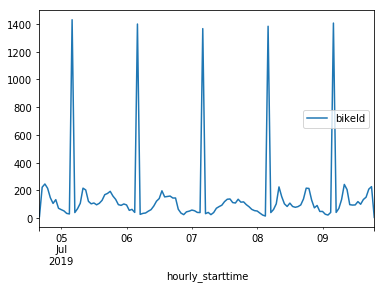

In [328]:
counts.plot()

In [389]:
df.loc[:,'daily_starttime'] = df.timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))

/Users/akapp/Documents/Allgemein/Packages/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/akapp/Documents/Allgemein/Packages/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [390]:
counts = df[(df['mode'] == 'trip')& df.providerId == 1][['bikeId', 'daily_starttime']].groupby(['daily_starttime']).count()

In [60]:
df[df.providerId == 1].sort_values('timestamp')

#### How many rides are there per day?

#### How long is the average ride (time and length)? How fast?

## Geoanalysis 

In [8]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [14]:
geometry = [Point(xy) for xy in zip(df.next_lon, df.next_lat)]
endpoints = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [20]:
gdf[['geometry']].head(1000).to_file('../../data/small_startpoints.geojson', Driver='GeoJSON')

In [16]:
gdf_vbb = gpd.read_file('../../data/haltestellen-berlin.geojson')

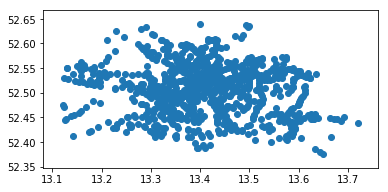

In [18]:
gdf_vbb.plot()

In [ ]:
gdf_plr = gpd.read_file('lor_planungsraeume.geojson')

In [ ]:
pointInPolys = sjoin(gdf_data.head(), gdf, how='left')

In [ ]:
gdf_data.intersects(gdf.unary_union)

In [ ]:
gpd.overlay(gdf, gdf_data)

#### Where are most rides? (Bezirk, ...) Heatmap

In [ ]:
ax = geoplot.kdeplot(gdf,
                     shade=True, shade_lowest=False,
                     clip=boroughs.geometry)
geoplot.polyplot(gdf_plr, ax=ax)

In [ ]:
# cross with Planungsräume

gdf.rename(index=str, columns={"spatial_name": "cell_id"}, inplace=True)
gdf[['cell_id', 'geometry']].to_file('planungsraeume.json', driver='GeoJSON')
df = pd.DataFrame(gdf)[['cell_id', 'geometry']]
gdf.set_index('cell_id', inplace=True)
gdf['geometry'].to_file('test2.json', driver='GeoJSON', index='False')
f= open("test.json","w")
f.write(gdf['geometry'].to_json())
f.close()    
test = gdf['geometry'].to_dict()
for key, values in test.items():
    print (key)
test = pd.read_json('test.json', orient='records')

#### What are highly frequented routes? (Are there good bike lanes? Should there be better bike lanes?)

#### Are there "hot spots" for pick up and drop off?

## Include further data

#### Intersect with subway stops

#### weather data

#### nextbike stations: with and without docking station: how many rides start from / end at a docking station